In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts
from metatensor.torch import Labels, TensorBlock, TensorMap

from mlelec.data.dataset import PySCFPeriodicDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic

/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [134]:
lam_a = torch.tensor(1)
lam_b = torch.tensor(2)
lam_a_tensor = torch.tensor(lam_a).expand(properties_a_tensor.size(0), 1)
lam_b_tensor = torch.tensor(lam_b).expand(properties_b_tensor.size(0), 1)

# Concatenate the eigenvalues to the properties tensors
prop_ids_a = torch.cat((properties_a_tensor, lam_a_tensor), dim=1)
prop_ids_b = torch.cat((properties_b_tensor, lam_b_tensor), dim=1)

/tmp/ipykernel_202639/2715687395.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lam_a_tensor = torch.tensor(lam_a).expand(properties_a_tensor.size(0), 1)


NameError: name 'properties_a_tensor' is not defined

In [132]:
a = torch.randn(10,10)
b = torch.tensor(1)#(1,10) 
torch.cat([a, b.unsqueeze(-1).unsqueeze(-1)])
# torch.dstack((a,b.view(1,1,1))).shape

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 10 but got size 1 for tensor number 1 in the list.

In [131]:
b.unsqueeze(-1).unsqueeze(-1)

tensor([[1]])

In [123]:
b.expand?

Docstring:
expand(*sizes) -> Tensor

Returns a new view of the :attr:`self` tensor with singleton dimensions expanded
to a larger size.

Passing -1 as the size for a dimension means not changing the size of
that dimension.

Tensor can be also expanded to a larger number of dimensions, and the
new ones will be appended at the front. For the new dimensions, the
size cannot be set to -1.

Expanding a tensor does not allocate new memory, but only creates a
new view on the existing tensor where a dimension of size one is
expanded to a larger size by setting the ``stride`` to 0. Any dimension
of size 1 can be expanded to an arbitrary value without allocating new
memory.

Args:
    *sizes (torch.Size or int...): the desired expanded size

.. warning::

    More than one element of an expanded tensor may refer to a single
    memory location. As a result, in-place operations (especially ones that
    are vectorized) may result in incorrect behavior. If you need to write
    to the tensors, ple

In [117]:
np.dstack?

Signature:       np.dstack(tup)
Call signature:  np.dstack(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function dstack at 0x7f3f781b2de0>
File:            ~/miniconda3/lib/python3.11/site-packages/numpy/lib/shape_base.py
Docstring:      
Stack arrays in sequence depth wise (along third axis).

This is equivalent to concatenation along the third axis after 2-D arrays
of shape `(M,N)` have been reshaped to `(M,N,1)` and 1-D arrays of shape
`(N,)` have been reshaped to `(1,N,1)`. Rebuilds arrays divided by
`dsplit`.

This function makes most sense for arrays with up to 3 dimensions. For
instance, for pixel-data with a height (first axis), width (second axis),
and r/g/b channels (third axis). The functions `concatenate`, `stack` and
`block` provide more general stacking and concatenation operations.

Parameters
----------
tup : sequence of arrays
    The arrays must have the same shape along all but the third axis.
    1-D or 2-D arrays must have the same s

In [3]:
device = 'cpu'

orbitals = {
    'sto-3g': {5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}, 
    
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
    'gthszvmolopt': {
        6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],
        
        16: [[3,0,0], 
             [3,1,-1], [3,1,0], [3,1,1]],

        42: [[4,0,0], 
             [5,0,0], 
             [4,1,-1], [4,1,0], [4,1,1], 
             [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]}
}

# QC dataset

In [4]:
# workdir = './'
# START = 0 
# STOP = 10
# ORBS = 'sto-3g'
# root = f'{workdir}/examples/data/periodic/deepH_graphene/wrap/'
# data_dir = root
# frames = read(f'{data_dir}/wrapped_deepH_graphene.xyz', slice(START, STOP))
# rfock = [np.load(f"{data_dir}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
# rover = [np.load(f"{data_dir}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
# kmesh = [1,1,1]
# dataset = PySCFPeriodicDataset(frames = frames, 
#                                kmesh = kmesh, 
#                                dimension = 2,
#                                fock_realspace = rfock, 
#                                overlap_realspace = rover, 
#                                device = device, 
#                                orbs = orbitals[ORBS], 
#                                orbs_name = 'sto-3g')

In [5]:
# workdir = './'
workdir = '/home/nigam/scratch/MAC'
root = f'{workdir}/data/hamiltonian/periodic/carbon_allotropes/'
# root = f'{workdir}/examples/data/periodic/carbon_allotropes'
ORBS = 'sto-3g'
kmesh = np.loadtxt(f'{root}/kmesh.dat', dtype=int)
START = 0
STOP = 2

indices = kmesh[:,0][START:STOP]
kmesh = kmesh[:,1:][START:STOP].tolist()

# frames = [read(f'{root}/{i}/cell_{i}.xyz') for i in indices]
frames = [read(f'{root}/cell_{i}.xyz') for i in indices]

for f in frames:
    f.wrap(center = (0,0,0), eps = 1e-30)
    # f.wrap(pretty_translation=True,eps=1e-20)

rfock=[np.load(f'{root}/realfock_{i}.npy', allow_pickle=True).item() for i in indices ]
rover=[np.load(f'{root}/realoverlap_{i}.npy', allow_pickle=True).item() for i in indices ]

In [6]:
dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=False,
                               dimension = 3,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

# Targets

In [7]:
cutoff = 8

In [8]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)

In [10]:
# from mlelec.metrics import L2_loss_meanzero as L2_loss
from mlelec.metrics import L2_loss
L2_loss(target_coupled_blocks,target_coupled_blocks, loss_per_block = True)

([tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.)],
 tensor(0.))

In [36]:
k_target_blocks = kmatrix_to_blocks(dataset, cutoff = cutoff)
# k_target_coupled_blocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff = cutoff), skip_symmetry = True, device = device, translations= False)

ValueError: `arrays` must be None or 'torch', got 'numpy' instead

In [30]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)
k_target_coupled_blocks = TMap_bloch_sums(target_coupled_blocks, phase, indices, kpts_idx, return_tensormap = True)

In [34]:
rHT = blocks_to_matrix(target_coupled_blocks, dataset)
rHk_BS = dataset.bloch_sum(rHT)

In [ ]:
rHk = kblocks_to_matrix(k_target_blocks, dataset)

In [33]:
for T in rHT[0]:
    print(torch.norm(rHT[0][T]-dataset.fock_realspace[0][T]))

tensor(6.6368e-21)
tensor(6.6368e-21)
tensor(4.7413e-17)
tensor(4.7413e-17)
tensor(6.5868e-21)
tensor(6.5868e-21)
tensor(3.7597e-17)
tensor(3.7597e-17)
tensor(2.2824e-15)
tensor(2.2824e-15)
tensor(3.4284e-17)
tensor(3.4284e-17)
tensor(7.0293e-21)
tensor(7.0293e-21)
tensor(4.4918e-17)
tensor(4.4918e-17)
tensor(6.7395e-21)
tensor(6.7395e-21)
tensor(3.7742e-17)
tensor(3.7742e-17)
tensor(2.2717e-15)
tensor(2.2717e-15)
tensor(3.5866e-17)
tensor(3.5866e-17)
tensor(1.7019e-15)
tensor(1.7019e-15)
tensor(1.2506e-13)


In [78]:
torch.stack([torch.tensor(1),torch.tensor(3),torch.tensor(4)])

tensor([1, 3, 4])

In [99]:
identity_matrices = torch.eye(10).expand(eigs.shape[0], -1, -1)

# Reshape eigs to be broadcastable and subtract from the identity matrices
eigs_expanded = eigs.view(eigs.shape[0], 1, 1)
result = torch.ones(64,10,10) - identity_matrices * eigs_expanded

In [102]:
eigs = torch.randn(64)


identity_matrices = torch.eye(10).expand(eigs.shape[0], -1, -1)
eigs_expanded = 
result = torch.ones(64,10,10) - identity_matrices * eigs.view(eigs.shape[0], 1, 1)

torch.norm(torch.stack([torch.ones(64,10,10)[i] - torch.eye(10)*eigs[i] for i in range(64)])-result)

tensor(0.)

In [103]:
result


tensor([[[ 1.6920,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.6920,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.6920,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  1.6920,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.6920,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.6920]],

        [[ 0.7005,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  0.7005,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  0.7005,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  0.7005,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  0.7005,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  0.7005]],

        [[-1.3855,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000, -1.3855,  1.0000,  ...,  1

In [81]:
torch.randn(64,10,10).shape

torch.Size([64, 10, 10])

# Features

In [9]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 7.85}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 3.85}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [72]:
from rascaline.torch import SphericalExpansion
from mlelec.features.acdc_utils import acdc_standardize_keys

calculator = SphericalExpansion(**hypers_atom)
rhoi = calculator.compute(rascaline.torch.systems_to_torch(frames))
rho1i = acdc_standardize_keys(rhoi)
from mlelec.features.acdc_utils import cg_combine, cg_increment
from mlelec.utils.symmetry import ClebschGordanReal
rho1i = rho1i.keys_to_properties(["species_neighbor"])

L = 4
cg = ClebschGordanReal(lmax = L, device = device)


In [73]:
%lprun -f cg_combine cg_combine(rho1i,rho1i,clebsch_gordan=cg,lcut=4,other_keys_match=["species_center"],device=device,)

Timer unit: 1e-09 s

Total time: 2.27594 s
File: /media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/features/acdc_utils.py
Function: cg_combine at line 212

Line #      Hits         Time  Per Hit   % Time  Line Contents
   212                                           def cg_combine(
   213                                               x_a,
   214                                               x_b,
   215                                               feature_names=None,
   216                                               clebsch_gordan=None,
   217                                               lcut=None,
   218                                               filter_sigma=[-1, 1],
   219                                               other_keys_match=None,
   220                                               mp=False,
   221                                               device=None,
   222                                               diagonal_radial_tensor=False
   22

In [ ]:
from mlelec.utils.twocenter_utils import lowdin_orthogonalize
H = dataset.fock_kspace
O = dataset.fock_kspace
lowdin_orthogonalize(h,s) for h, s in zip(hh,oo) for hh,

In [68]:
rho1i

TensorMap with 5 blocks
keys: order_nu  spherical_harmonics_l  inversion_sigma  species_center  species_neighbor
         1                0                   1               6                6
         1                1                   1               6                6
         1                2                   1               6                6
         1                3                   1               6                6
         1                4                   1               6                6

In [ ]:
features = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT)
# rhonui, rhoij = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT)

In [27]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

In [41]:
# pair = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = False, both_centers = False, kmesh = dataset.kmesh,
#                                    device = device, lcut = 3, return_rho0ij = False)  
single = single_center_features(dataset.structures, hypers_atom, order_nu = 2, lcut = 3, device = device,)

cpu single center features


In [34]:
%lprun -f pair_features pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = False, both_centers = False, kmesh = dataset.kmesh, device = device, lcut = 3, return_rho0ij = False)  

cpu pair features
cpu single center features


Timer unit: 1e-09 s

Total time: 53.1997 s
File: /media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/features/acdc.py
Function: pair_features at line 85

Line #      Hits         Time  Per Hit   % Time  Line Contents
    85                                           def pair_features(
    86                                               frames: List[ase.Atoms],
    87                                               hypers: Dict,
    88                                               hypers_pair: Dict = None,
    89                                               cg=None,
    90                                               rhonu_i: TensorMap = None,
    91                                               order_nu: Union[
    92                                                   List[int], int
    93                                               ] = None,  # List - useful when combining nu on i and nu' on j
    94                                               all_pairs: bool = 

In [45]:
%lprun -f single_center_features single_center_features(dataset.structures, hypers_atom, order_nu = 2, lcut = 3, device = device,)

cpu single center features


Timer unit: 1e-09 s

Total time: 2.34718 s
File: /media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/features/acdc.py
Function: single_center_features at line 33

Line #      Hits         Time  Per Hit   % Time  Line Contents
    33                                           def single_center_features(
    34                                               frames, hypers, order_nu, lcut=None, cg=None, device="cpu", **kwargs
    35                                           ):  
    36         1      67735.0  67735.0      0.0      print(device, 'single center features')
    37         1    2367276.0    2e+06      0.1      calculator = SphericalExpansion(**hypers)
    38         1    8566485.0    9e+06      0.4      rhoi = calculator.compute(rascaline.torch.systems_to_torch(frames), use_native_system = use_native)
    39         1   41778420.0    4e+07      1.8      rho1i = acdc_standardize_keys(rhoi)
    40         1    1481840.0    1e+06      0.1      rho1i = rho1i.keys

In [47]:
%lprun -f twocenter_features_periodic_NH twocenter_features_periodic_NH(single, pair, all_pairs=False)

Timer unit: 1e-09 s

Total time: 5.20056 s
File: /media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/features/acdc.py
Function: twocenter_features_periodic_NH at line 279

Line #      Hits         Time  Per Hit   % Time  Line Contents
   279                                           def twocenter_features_periodic_NH(
   280                                               single_center: TensorMap, pair: TensorMap, all_pairs = False, device = 'cpu'
   281                                           ) -> TensorMap:
   282         1       8329.0   8329.0      0.0      from collections import defaultdict
   283                                           
   284         1        687.0    687.0      0.0      keys = []
   285         1        399.0    399.0      0.0      blocks = []
   286         1      76302.0  76302.0      0.0      if "cell_shift_a" not in pair.keys.names:
   287         1      20107.0  20107.0      0.0          assert "cell_shift_b" not in pair.keys.names
 

In [58]:
from mlelec.features.acdc import twocenter_features_periodic_NH
features = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = False)

(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)


In [40]:
for k, b in rhoij.items():
    print(k.values, b.values.norm().item())

tensor([2, 1, 0, 6, 6], dtype=torch.int32) 10.773650516590463
tensor([2, 1, 1, 6, 6], dtype=torch.int32) 12.486863174937385
tensor([2, 1, 2, 6, 6], dtype=torch.int32) 16.10967898875837
tensor([2, 1, 3, 6, 6], dtype=torch.int32) 17.82078825850425
tensor([ 2, -1,  1,  6,  6], dtype=torch.int32) 2.7059857989244778
tensor([ 2, -1,  2,  6,  6], dtype=torch.int32) 5.6042021146216925
tensor([ 2, -1,  3,  6,  6], dtype=torch.int32) 6.182463228040975


In [13]:
import torch.nn as nn
from mlelec.models.linear import MLP

class featmodel(nn.Module):
    def __init__(self,
                 features,
                 device=None,
                 apply_norm = False, 
                 **kwargs):

        super().__init__()
        self.features = features 
        self.apply_norm = apply_norm
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else: 
            self.device = device
        self._submodels(set_bias=kwargs.get("bias", False), **kwargs)

    def _submodels(self, set_bias=False, **kwargs):
        self.blockmodels = {}
        for k, feat in self.features.items():
            bias = False
            if k["spherical_harmonics_l"] == 0 and set_bias:
                bias = True
            self.blockmodels[str(tuple(k))] = MLP(
                nin=feat.values.shape[-1],
                nout=feat.values.shape[-1],
                nhidden=kwargs.get("nhidden", 16),
                nlayers=kwargs.get("nlayers", 2),
                bias=bias,
                activation=kwargs.get("activation", None),
                
                # activation_with_linear=kwargs.get("activation_with_linear", False),
                apply_layer_norm=self.apply_norm,
            )
        self.model = torch.nn.ModuleDict(self.blockmodels)
        self.model.to(self.device)

    def forward(self, features = None):
        pred_blocks = []
        if features is None:
            features = self.features
        keys = features.keys
        preds=[]
        for k, feat in features.items():
            pred = self.blockmodels[str(tuple(k))](feat.values)
            # preds.append(pred)
            pred_blocks.append(
                    TensorBlock(
                        values = pred,#.reshape((nsamples, ncomp, 1)),
                        samples = feat.samples,
                        components = feat.components,
                        properties = feat.properties,
                    )
                )
            pred = None
        
        # # del features
        return TensorMap(keys, pred_blocks)
        # return preds

In [47]:
fmodel = featmodel(
    features, 
    apply_norm=True, 
    nhidden=[100,50,25,50,100],
    nlayers = 5,
    activation = 'SiLU',
    bias=True,
    device='cpu'
)

In [48]:
fmodel = fmodel.double()

nepoch = 1000

optimizers = []
schedulers = []
for i, key in enumerate(fmodel.model):
    optimizers.append(torch.optim.Adam(fmodel.model[key].parameters(), lr = 1e-3)) #, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.5, patience = 100, verbose=True))

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
from metatensor.learn import Dataset, DataLoader, IndexedDataset
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts
import metatensor.torch as mts
from mlelec.data.dataset import split_by_Aij
from mlelec.metrics import L2_loss

In [17]:
split_by_axis = "samples"
split_by_dimension = "structure"


grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features = mts.split(features, split_by_axis, grouped_labels)

In [18]:
ml_data = IndexedDataset(descriptor = split_features, target = split_features, sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

In [52]:
batch_size = 1
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = False, 
                        collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))


In [53]:
LOSS_LIST = []

fmodel.train(True)

nepoch = 1000

for epoch in range(nepoch):
    LOSS = 0
    lr = []
    for ib, batch in enumerate(dataloader):
    # if True:
        for ik, key in enumerate(fmodel.model):
            optimizers[ik].zero_grad()
        
        pred = fmodel.forward(batch.descriptor)
        # pred = mts.detach(pred)

        # all_losses = [torch.norm(p - t.values)**2 for p, t in zip(pred, batch.target.blocks())]
        
        # Compute the loss for each block
        # all_losses, epoch_loss = L2_loss(pred, batch.target, loss_per_block = True)
        # all_losses = [b.values.sum() for b in mts.pow(mts.subtract(pred, features), 2).blocks()]
        all_losses = [b.values.sum() for b in mts.pow(mts.subtract(pred, batch.target), 2).blocks()]
        epoch_loss = sum(all_losses).item()

        # # Total loss
        # epoch_loss = epoch_loss.item()
        LOSS += epoch_loss

        # # Loop through submodels and backpropagate
        for ik, (loss, key) in enumerate(zip(all_losses, fmodel.model)):
            loss.backward(retain_graph = False)
            torch.nn.utils.clip_grad_norm_(fmodel.model[key].parameters(), 1)
            optimizers[ik].step()
            schedulers[ik].step(loss)
            lr.append(schedulers[ik].get_last_lr())
        pred = None
    if epoch % 1 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        LOSS_LIST.append(LOSS)
        print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}, avg lr = {np.mean(lr):e}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

0
1
2
3
4
5
6
7
8
9
Epoch       0, train loss 230336.3355008756, avg lr = 1.000000e-03
10
11
12
13
14
15
16
17
18
19
Epoch       1, train loss 77904.1096147080, avg lr = 1.000000e-03
20
21
22
23
24
25
26
27
28
29
Epoch       2, train loss 25551.8496585524, avg lr = 1.000000e-03
30
31
32
33
34
35
36
37
38
39
Epoch       3, train loss 10850.6651731825, avg lr = 1.000000e-03
40
41
42
43
44
45
46
47
48
49
Epoch       4, train loss 8234.3167935514, avg lr = 1.000000e-03
50
51
52
53
54
55
56
57
58
59
Epoch       5, train loss 6218.9029183814, avg lr = 1.000000e-03
60
61
62
63
64
65
66
67
68
69
Epoch       6, train loss 3701.4842569141, avg lr = 1.000000e-03
70
71
72
73
74
75
76
77
78
79
Epoch       7, train loss 2722.1607762002, avg lr = 1.000000e-03
80
81
82
83
84
85
86
87
88
89
Epoch       8, train loss 1921.4624895466, avg lr = 1.000000e-03
90
91
92
93
94
95
96
97
98
99
Epoch       9, train loss 1701.9677207885, avg lr = 1.000000e-03
100
101
102
103
104
105
106
107
108
109
Epoch      10, 


KeyboardInterrupt



In [39]:
sum(b.values.sum() for b in mts.pow(mts.subtract(pred, batch.target), 2).blocks())

tensor(17877.4226, grad_fn=<AddBackward0>)

# ML Dataset/Dataloader

In [35]:
from metatensor.learn import Dataset, DataLoader, IndexedDataset
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts
import metatensor.torch as mts

In [36]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(target_coupled_blocks, axis = split_by_axis, names = split_by_dimension)]
split_target = mts.split(target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features = mts.split(features, split_by_axis, grouped_labels)

In [37]:
ml_data = IndexedDataset(descriptor = split_features, target = split_target, sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

Split kspace targets

In [17]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(k_target_coupled_blocks, axis = split_by_axis, names = split_by_dimension)]
split_target_k = mts.split(k_target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features_k = mts.split(features, split_by_axis, grouped_labels)

In [18]:
ml_data_k = IndexedDataset(descriptor = split_features_k, target = split_target_k, sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

# Ridge regression

In [38]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [39]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [40]:
model_ridge = LinearModelPeriodic(twocfeat = features, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-9, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0103)


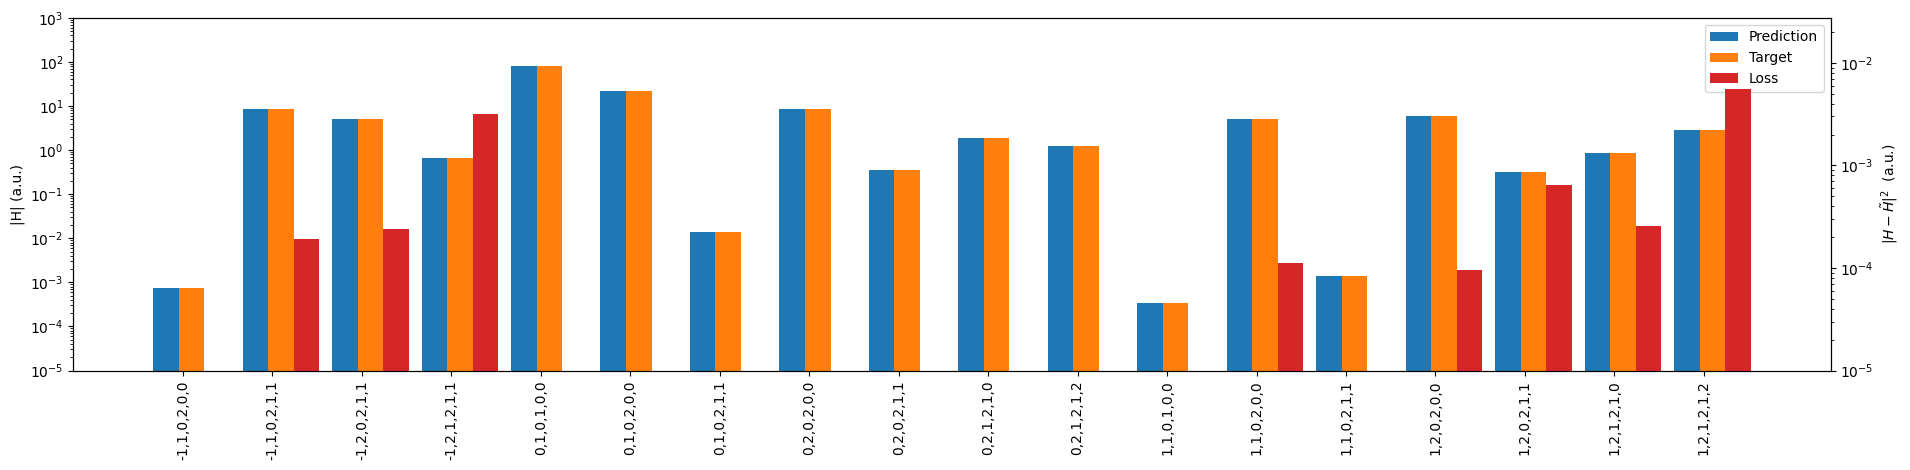

In [41]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

# Train

In [42]:
# from mlelec.metrics import L2_loss
from mlelec.metrics import L2_loss_meanzero as L2_loss
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

In [43]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = features, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = 'cpu',
                            bias = True,
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

nepoch = 1000

optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = 1e-3)) #, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.5, patience = 100, verbose=True))

/home/nigam/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [44]:
from metatensor.learn import DataLoader

batch_size = 1
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))
# dataloader_k = DataLoader(ml_data_k, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [45]:
# %%timeit -n 1 -r 1

train_kspace = False
LOSS_LIST = []

nepoch = 1000
for epoch in range(nepoch):

    if epoch >= 1000:
        train_kspace = True

    if not train_kspace:
        # Train against real space targets
        LOSS = 0
        lr = []
        for ib, batch in enumerate(dataloader):
            
            model.train(True)
            
            for ik, key in enumerate(model.model):
                optimizers[ik].zero_grad()
            
            pred = model.predict_batch(batch.descriptor, batch.target)
            
            # Compute the loss for each block
            all_losses, epoch_loss = L2_loss(pred, batch.target, loss_per_block = True)
    
            # Total loss
            epoch_loss = epoch_loss.item()
            LOSS += epoch_loss
    
            # Loop through submodels and backpropagate
            for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
                loss.backward(retain_graph = False)
                torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
                optimizers[ik].step()
                schedulers[ik].step(loss)
                lr.append(schedulers[ik].get_last_lr())
    else:
        # Train against k-space targets
    
        LOSS = 0
        lr = []
        for ib, batch in enumerate(dataloader_k):

            model.train(True)
    
            for ik, key in enumerate(model.model):
                optimizers[ik].zero_grad()
            
            pred = model.predict_batch(batch.descriptor)
            pred_kspace = TMap_bloch_sums(pred, phase, indices, kpts_idx, return_tensormap = True)
            
            # Compute the loss
            loss = L2_loss(pred_kspace, batch.target, norm = 2*np.prod(dataset.kmesh[0]))
    
            # Total loss 
            epoch_loss = loss.item()
            LOSS += epoch_loss
                   
            loss.backward(retain_graph = True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            for ik, key in enumerate(model.model):
                optimizers[ik].step()
                schedulers[ik].step(epoch_loss/len(model.model))
                lr.append(schedulers[ik].get_last_lr())

    if epoch >= 0: #% 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        LOSS_LIST.append(LOSS)
        print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}, avg lr = {np.mean(lr)}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss 1673.9674359959, avg lr = 0.001
Epoch       1, train loss 1460.9324746273, avg lr = 0.001
Epoch       2, train loss 1285.9853019659, avg lr = 0.001
Epoch       3, train loss 1131.3154823300, avg lr = 0.001
Epoch       4, train loss  994.0556602981, avg lr = 0.001
Epoch       5, train loss  872.2992500975, avg lr = 0.001
Epoch       6, train loss  762.6585825050, avg lr = 0.001
Epoch       7, train loss  664.4145046064, avg lr = 0.001
Epoch       8, train loss  578.5074587574, avg lr = 0.001
Epoch       9, train loss  504.2323796783, avg lr = 0.001
Epoch      10, train loss  440.2537368943, avg lr = 0.001
Epoch      11, train loss  384.7356669751, avg lr = 0.001
Epoch      12, train loss  335.9359956916, avg lr = 0.001
Epoch      13, train loss  292.2298364601, avg lr = 0.001
Epoch      14, train loss  252.8592503808, avg lr = 0.001
Epoch      15, train loss  217.5989020099, avg lr = 0.001
Epoch      16, train loss  186.4622250478, avg lr = 0.001
Epoch      17,

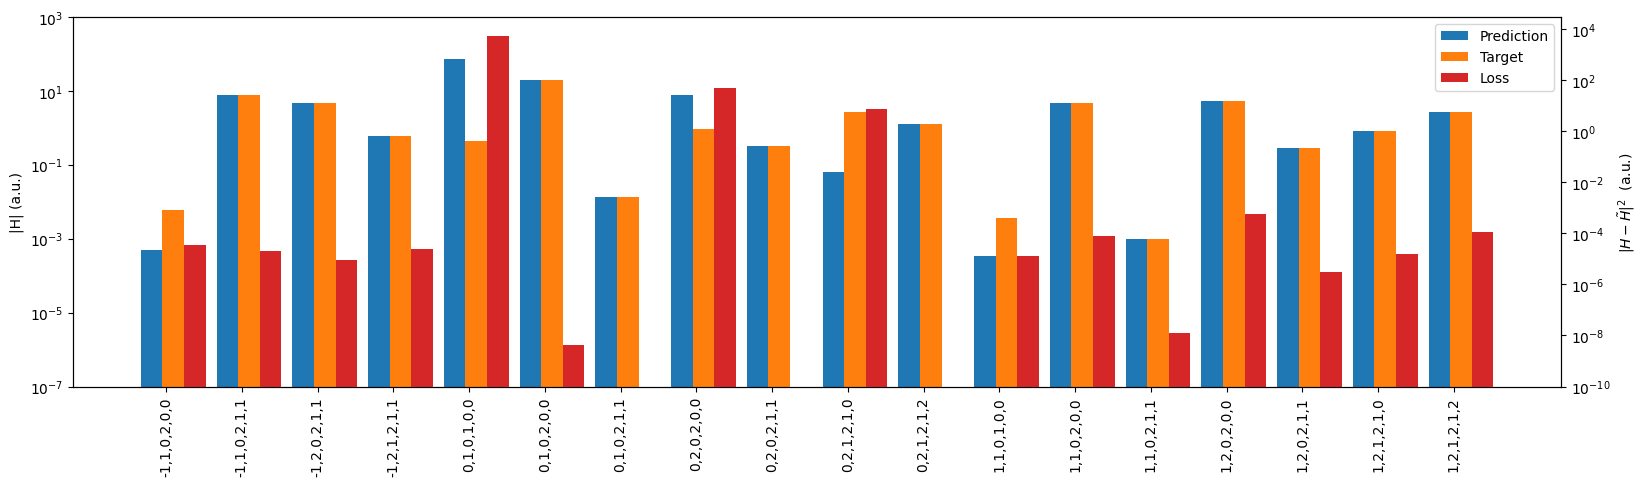

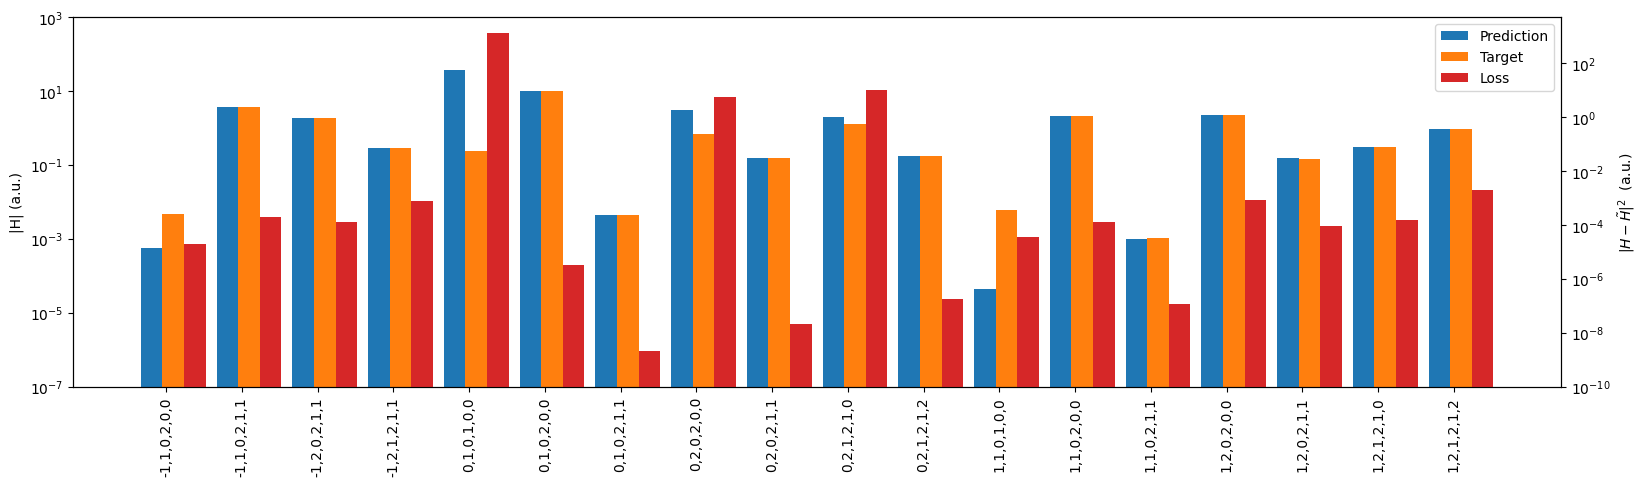

In [59]:
# pred = model.predict_batch(batch.descriptor)
for ib, batch in enumerate(dataloader):
    pred = model.predict_batch(batch.descriptor, batch.target)
    plot_block_errors(pred, batch.target, plot_loss=True)

In [54]:
for ib, batch in enumerate(dataloader):
    pred = model.predict_batch(batch.descriptor, batch.target)
    print(ib, L2_loss(pred, batch.target))

0 tensor(0.0009, grad_fn=<AddBackward0>)
1 tensor(0.0043, grad_fn=<AddBackward0>)


In [56]:
L2_loss(model.predict_batch(features, target_coupled_blocks), target_coupled_blocks)

tensor(4.5570, grad_fn=<AddBackward0>)

In [50]:
checkpoint = torch.load('/home/pegolo/Software/mlelec/examples/data/periodic/deepH_graphene/models/model_1500.ckpt')

In [149]:
allo_checkpoint = torch.load('./examples/data/periodic/carbon_allotropes/allotropes_model_1700.ckpt')

In [131]:
from mlelec.models.linear import LinearModelPeriodic
graphene_model = LinearModelPeriodic(twocfeat = features, 
                                     target_blocks = target_coupled_blocks,
                                     frames = dataset.structures, orbitals = dataset.basis, 
                                     device = device,
                                     bias = True,
                                     nhidden = 128, 
                                     nlayers = 2,
                                     activation = 'SiLU',
                                     apply_norm = True)
graphene_model = graphene_model.double()

In [150]:
from mlelec.models.linear import LinearModelPeriodic
allo_model = LinearModelPeriodic(twocfeat = features, 
                                     target_blocks = target_coupled_blocks,
                                     frames = dataset.structures, orbitals = dataset.basis, 
                                     device = device,
                                     bias = True,
                                     nhidden = 128, 
                                     nlayers = 2,
                                     activation = 'SiLU',
                                     apply_norm = True)
allo_model = allo_model.double()

In [151]:
allo_model.load_state_dict(allo_checkpoint['model_state_dict'])

<All keys matched successfully>

In [152]:
pred_from_allo = allo_model.predict(features, target_coupled_blocks)

In [153]:
L2_loss(pred_from_allo, target_coupled_blocks)

tensor(511.6308, grad_fn=<AddBackward0>)

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| (a.u.)'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$  (a.u.)'>)

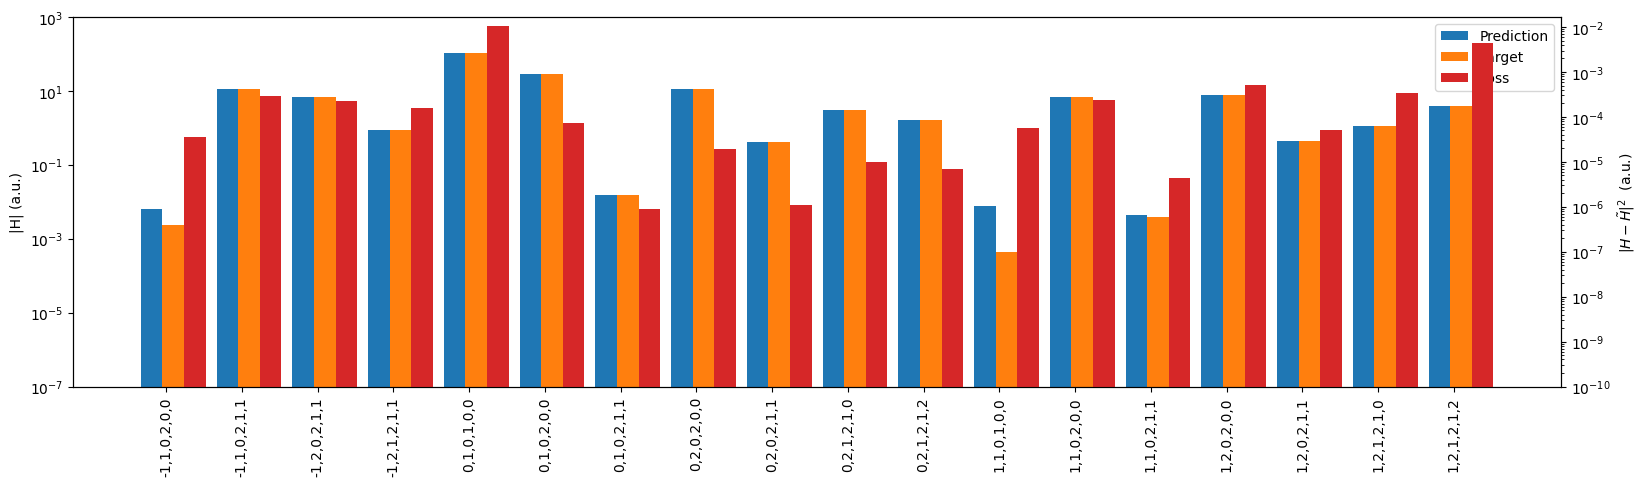

In [29]:
pred = model()
plot_block_errors(target_coupled_blocks, pred, plot_loss=True)

In [289]:
recon_HT = blocks_to_matrix(pred, dataset)

In [290]:
recon_Hk = dataset.bloch_sum(recon_HT)

In [291]:
cutoff_overlaps = blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff, target='overlap'), dataset)

In [292]:
recon_Sk = dataset.bloch_sum(cutoff_overlaps)

In [293]:
from scipy.linalg import eigvalsh
eigvals_target = {}
eigvals_pred = {}
for A in range(len(dataset)):
    eigvals_target[A] = []
    eigvals_pred[A] = []
    for ik in range(len(dataset.fock_kspace[A])):
        eigvals_target[A].append(eigvalsh(dataset.fock_kspace[A][ik].numpy(), dataset.overlap_kspace[A][ik].numpy()))
        eigvals_pred[A].append(eigvalsh(recon_Hk[A][ik].detach().numpy(), recon_Sk[A][ik].detach().numpy()))

In [294]:
view(dataset.structures)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

(-2.0, 2.0)

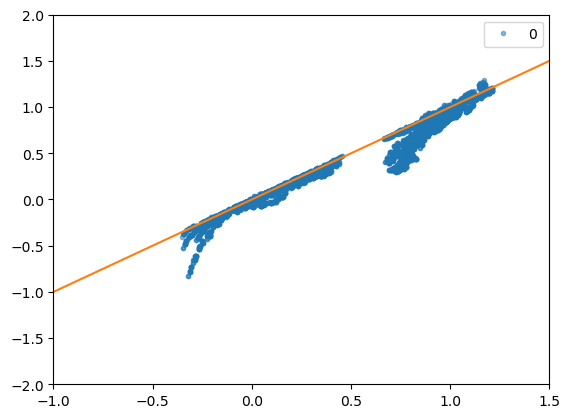

In [298]:
for A in eigvals_target:
    # if A != 2:
        plt.plot(np.concatenate(eigvals_target[A]), np.concatenate(eigvals_pred[A]), '.', alpha = 0.5, label = A)
plt.plot([-11,2], [-11,2])
# plt.plot([-1,2], [-1,2])
plt.legend()
# plt.xlim(-9.78,-9.7)
# plt.ylim(-9.78,-9.7)
plt.xlim(-1,1.5)
plt.ylim(-2,2)

In [161]:
sum(np.concatenate(eigvals_target)<-8)

720

[]

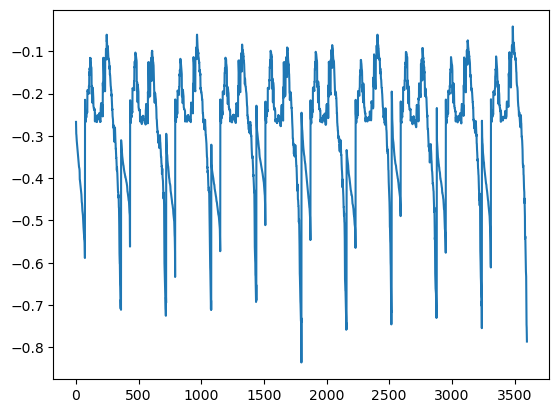

In [162]:
plt.plot(np.concatenate(eigvals_target) - np.concatenate(eigvals_pred))
plt.plot()

In [147]:
view(frames)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

# Meh

In [59]:
split_features, split_target = split_by_Aij(target_coupled_blocks, features = features)

## Using tensormaps

In [65]:
split_features, split_target = split_by_Aij_mts(target_coupled_blocks, features = features)

In [66]:
ml_data = IndexedDataset(descriptor = list(split_features.values()), target = list(split_target.values()), sample_id = list(split_target.keys()))

In [111]:
batch_size = 20
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = True, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [92]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)

In [112]:
kmap = []
for batch in dataloader:
    kmap.append(TMap_bloch_sums(batch.target, phase, indices, kpts_idx, return_tensormap = True))

## Debug

In [487]:
from mlelec.utils.plot_utils import block_matrix_norm, matrix_norm

In [ ]:
rij, Hij = block_matrix_norm(target_coupled_blocks, dataset)

In [280]:
rij_, fij = block_matrix_norm(features, dataset)

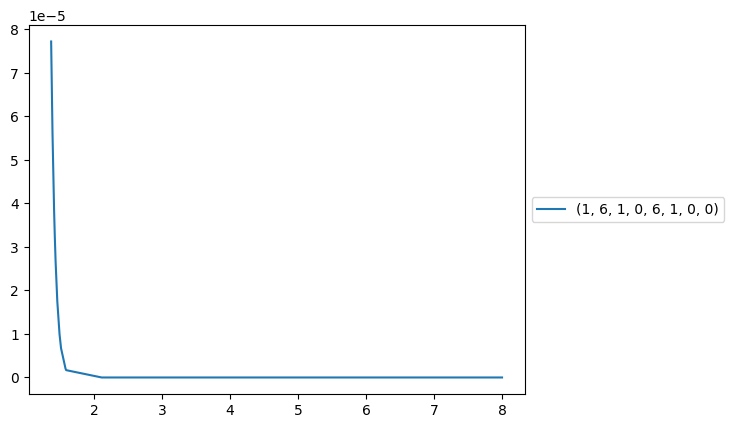

In [219]:
for k in rij:
    if k[0] == 1 and k[-1]==0 and k[3]==0 and k[5]==1:
        x = np.array(rij[k])
        y = np.array(Hij[k])
        plt.plot(x[x.argsort()], y[x.argsort()], '-', label = k)
# plt.ylim(-1e-3,1)
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

In [260]:
from rascaline import SphericalExpansionByPair
from mlelec.features.acdc_utils import acdc_standardize_keys
gij = SphericalExpansionByPair(**hypers_pair).compute(frames)
gij = acdc_standardize_keys(gij)
rij_, fij = block_matrix_norm(gij, dataset)

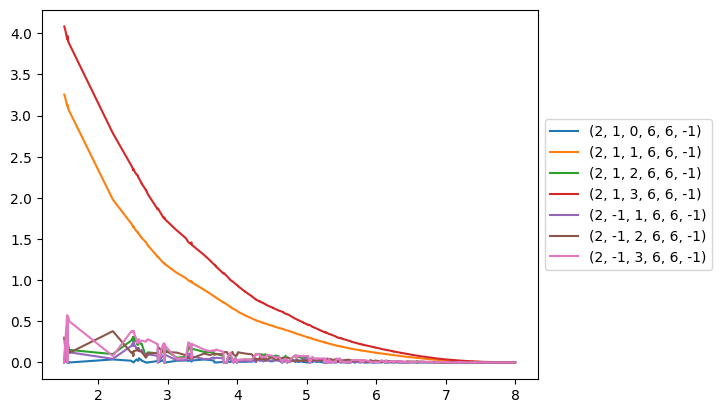

In [282]:
for k in rij_:
    # if k[0] == 1 and k[-1]==0 and k[3]==0 and k[5]==1:
    if k[-1]==-1:
    
        x = np.array(rij_[k])
        y = np.array(fij[k])
        plt.plot(x[x.argsort()], y[x.argsort()], '-', label = k)
# plt.ylim(-1e-3,1)
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

In [148]:
ht = blocks_to_matrix(target_blocks, dataset)
ht_=[]
for ifr in range(len(rht)):
    ht_.append(torch.stack(list(ht[ifr].values())).flatten())
ht_ = torch.cat(ht_)

In [167]:
from ase.units import Hartree
lossfn = nn.L1Loss()
# lossfn = nn.MSELoss()
lossfn(rht_,ht_)*Hartree*1000

tensor(0.1531)